## Финальный проект
### **Вариант: 1**

Описание:

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

1. В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
3. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

Импортируем все необходимые библиотеки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

plt.style.use('ggplot')

#### *Задание 1*
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).
Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.


In [2]:
# Считаем наши данные
auth_df = pd.read_csv('problem1-auth_data.csv', sep=';')
reg_df = pd.read_csv('problem1-reg_data.csv', sep=';')

Предполагается, что предобработка данных уже была проведена

---

Первая функция `retention_rate_by_period` возвращает DataFrame с retention временного отрезка, если `styled=False` и стилизованную таблицу (объект styler), если `styled=True`

In [3]:
def retention_rate_by_period(
        reg_data, auth_data, start_date, end_date, styled=False):
    '''
    Функция рассчитвает retention rate для определенного периода по дням.
    Аргументы функции:
    reg_data - объект типа DataFrame с данными о регистрации пользователей
    auth_data - объект типа DataFrame с данными о аутентификации пользователей
    start_date - переменная типа str с начальной границей период
    в виде YYYY-MM-DD
    end_date - переменная типа str с конечной границей периода
    в виде YYYY-MM-DD
    styled - переменная типа bool, флаг стилизации таблицы (по умолчанию False)
    Функция возвращает DataFrame с подсчитанным retention rate для каждой
    когорты из указанного периода за каждый день
    '''
    if start_date > end_date:
        return 'Некорректная дата'
      
    reg_data['reg_date'] = pd.to_datetime(
        pd.to_datetime(reg_data.reg_ts, unit='s').dt.date)
    auth_data['auth_date'] = pd.to_datetime(
        pd.to_datetime(auth_data.auth_ts, unit='s').dt.date)
    try:
        full_data = auth_data \
            .merge(reg_data, how='left', on='uid') \
            .query(
                '@start_date <= reg_date and auth_date <= @end_date'
            )[['uid', 'auth_date', 'reg_date']]
    except ValueError:
        return 'Некорректная дата'

    full_data['cohort'] = (full_data.auth_date - full_data.reg_date).dt.days

    result_df = full_data \
        .groupby(['reg_date', 'cohort'], as_index=False) \
        .agg({'uid': 'nunique'})

    result_df['registrations_per_date'] = result_df \
        .groupby('reg_date') \
        .uid \
        .transform(max)

    result_df['retantion_rate'] = round(
        result_df.uid / result_df.registrations_per_date,
        3
    )

    result_df = result_df \
        .pivot(index='reg_date', columns='cohort', values='retantion_rate') \
        .merge(
            result_df[
                ['reg_date', 'registrations_per_date']
            ].drop_duplicates(),
            on='reg_date', how='left'
        )

    cols = list(result_df)
    cols.insert(1, cols.pop(cols.index('registrations_per_date')))
    result_df = result_df.reindex(columns=cols)
    result_df['reg_date'] = result_df['reg_date'].dt.strftime("%Y-%m-%d")
    result_df.rename(columns={
        'reg_date': 'Дата регистрации',
        'registrations_per_date': 'Кол-во регистраций'
    }, inplace=True)

    if styled:
        result_df = result_df \
            .style \
            .set_caption(
                f'Дневной коэффициент удержания клиентов в период'
                f' с {start_date} по {end_date}.'
            ) \
            .format("{:.1%}", na_rep="", subset=result_df.columns.drop(
                ['Дата регистрации', 'Кол-во регистраций'])) \
            .hide_index() \
            .background_gradient(cmap='Purples', subset=result_df.columns.drop(
                ['Дата регистрации', 'Кол-во регистраций'])) \
            .highlight_null('grey')
        return result_df

    return result_df

In [4]:
retention_rate_by_period(
    reg_df, auth_df, "2018-02-01", "2018-02-17", styled=True)

Дата регистрации,Кол-во регистраций,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
2018-02-01,337,100.0%,3.0%,3.3%,4.7%,6.2%,4.2%,5.3%,6.8%,5.3%,4.7%,4.2%,4.7%,4.5%,3.3%,4.7%,3.9%,3.9%
2018-02-02,337,100.0%,1.5%,2.7%,4.7%,3.3%,6.5%,6.8%,7.7%,3.9%,6.5%,5.0%,6.5%,3.9%,4.7%,2.4%,5.0%,
2018-02-03,337,100.0%,2.4%,4.7%,5.3%,6.2%,7.1%,7.1%,7.7%,8.6%,5.3%,6.2%,3.9%,5.9%,5.3%,5.9%,,
2018-02-04,338,100.0%,2.4%,4.4%,4.7%,5.6%,6.2%,9.2%,5.6%,2.7%,7.1%,3.8%,7.7%,5.9%,3.8%,,,
2018-02-05,339,100.0%,1.8%,2.9%,7.1%,3.8%,5.6%,8.6%,7.4%,7.4%,3.2%,5.3%,5.3%,6.8%,,,,
2018-02-06,339,100.0%,1.8%,4.4%,4.4%,4.4%,8.0%,5.9%,6.5%,2.4%,5.3%,4.4%,5.3%,,,,,
2018-02-07,339,100.0%,2.7%,2.4%,5.9%,4.4%,5.9%,7.7%,4.4%,3.2%,4.1%,4.7%,,,,,,
2018-02-08,341,100.0%,2.3%,2.1%,6.2%,4.4%,7.6%,6.7%,5.9%,2.9%,5.3%,,,,,,,
2018-02-09,340,100.0%,1.5%,3.2%,4.7%,4.4%,4.7%,7.6%,6.2%,4.1%,,,,,,,,
2018-02-10,342,100.0%,2.6%,4.4%,2.9%,7.0%,7.9%,8.8%,4.7%,,,,,,,,,


---

Вторая функция `full_retention_rate` возвращает DataFrame с подсчитанным retention rate за весь период для всех пользователей и выводит график его изменения, начиная с первого дня (нулевой день не отображен на графике)

In [5]:
def full_retention_rate(reg_data, auth_data):
    '''
    Функция строит график retenrion rate за весь период (кроме 0 дня)
    и возвращает DataFrame со столбцами: ['cohort', 'retention_rate']
    Аргументы:
    reg_data - объект типа DataFrame с данными о регистрации пользователей
    auth_data - объект типа DataFrame с данными о аутентификации пользователей
    '''

    reg_data['reg_date'] = pd.to_datetime(
        pd.to_datetime(reg_data.reg_ts, unit='s').dt.date)

    auth_data['auth_date'] = pd.to_datetime(
        pd.to_datetime(auth_data.auth_ts, unit='s').dt.date)

    full_data = auth_data \
        .merge(
            reg_data,
            how='left',
            on='uid')[['uid', 'auth_date', 'reg_date']]

    full_data['cohort'] = (full_data.auth_date - full_data.reg_date).dt.days

    result_df = full_data.groupby('cohort', as_index=False) \
        .agg(retention_rate=('uid', 'nunique'))

    max_users = reg_data.shape[0]
    result_df['retention_rate'] = result_df.retention_rate / max_users * 100

    plt.figure(figsize=(15, 10))
    ax = sns.lineplot(data=result_df.iloc[1:], x='cohort', y='retention_rate')
    ax.set_title(
        f'Retention rate за период с первого дня по '
        f'{result_df.cohort.max()} день')
    plt.xlabel('Дни')
    plt.ylabel('Retention rate')
    ax.yaxis.set_ticks(np.arange(0, 8, 0.5, dtype='float'))
    ax.set_yticklabels(
        ['{:.1f}%'.format(x) for x in ax.get_yticks()]
    )
    sns.despine()
    plt.show()
    return result_df

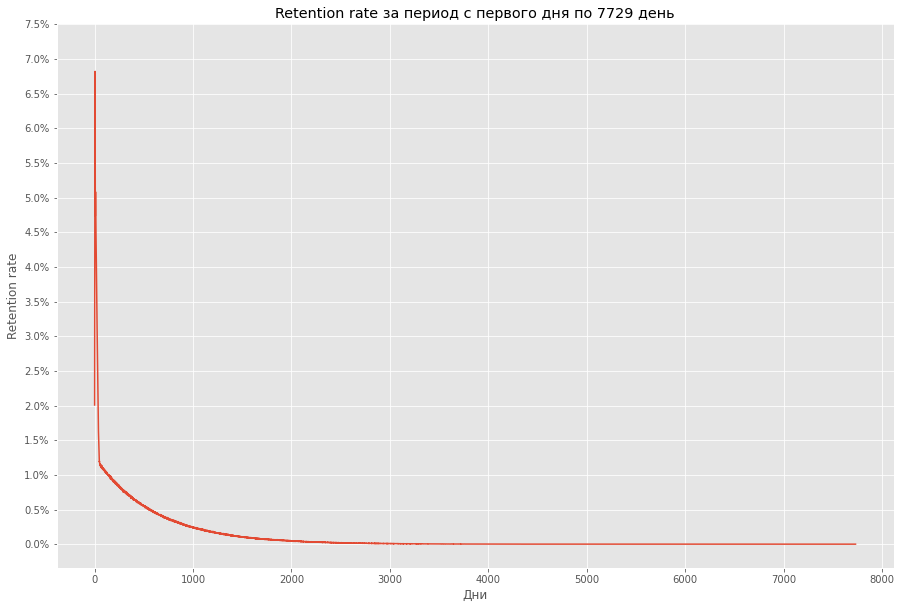

In [6]:
retention_df = full_retention_rate(reg_df, auth_df)

In [7]:
retention_df.head(10)

,cohort,retention_rate
0,0,100.0000
1,1,2.0071
2,2,4.0997
3,3,4.6338
4,4,5.2258
5,5,5.9863
6,6,6.8194
7,7,5.8140
8,8,4.7335
9,9,5.0222


---

#### *Задание 2*
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

* *Пункт 1 (Предобработка)*

Для начала посмотрим на наши данные 

In [8]:
ab_df = pd.read_csv('AB_data.csv', sep=';')

In [9]:
ab_df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [10]:
ab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [11]:
# Добавим столбец is_client

ab_df['is_client'] = ab_df.revenue > 0

In [12]:
# Разделим таблицу на тестовую и контрольную группы

test_df = ab_df.query('testgroup == "b"')
control_df = ab_df.query('testgroup == "a"')

In [13]:
# Убедимся, что правильно выбрали тестовую и контрольную группы

print('Численность тестовой группы:', test_df.shape[0])
print('Численность контрольной группы:', control_df.shape[0])

Численность тестовой группы: 202667
Численность контрольной группы: 202103


---

* *Пункт 2 (ARPU)*

Посмотрим, как различается средний чек на пользователя по этим группам (ARPU)

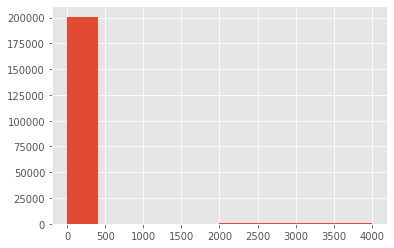

In [14]:
test_df.revenue.hist()

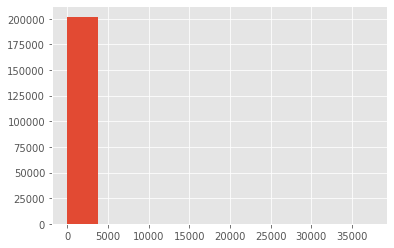

In [15]:
control_df.revenue.hist()

In [16]:
control_df.is_client.value_counts(normalize=True)

False    0.99046
True     0.00954
Name: is_client, dtype: float64

In [17]:
test_df.is_client.value_counts(normalize=True)

False    0.991094
True     0.008906
Name: is_client, dtype: float64

Как видим - в обеих группах 99% пользователей являются неплатящими

In [18]:
control_ARPU = control_df.revenue.mean()

In [19]:
test_ARPU = test_df.revenue.mean()

In [20]:
ARPU_diff = round((test_ARPU - control_ARPU) / control_ARPU * 100, 2)

In [21]:
print('ARPU в тестовой группе на {:.2f}% выше, чем в контрольной'
      .format(ARPU_diff))

ARPU в тестовой группе на 5.26% выше, чем в контрольной


Мы удостоверились, что разница в ARPU согласуется с условием задачи, теперь нужно проверить данную разницу на статистическую значимость

In [22]:
# Визуально распределения не выглядят нормальными,
# убедимся в этом с помощью теста Шапиро-Уилка

print(stats.shapiro(control_df.revenue.sample(1000, random_state=17)))
print(stats.shapiro(test_df.revenue.sample(1000, random_state=17)))

ShapiroResult(statistic=0.06614720821380615, pvalue=0.0)
ShapiroResult(statistic=0.06715953350067139, pvalue=0.0)


Тест Шапиро-Уилка проверяет нулевую гипотезу о том, что выборка была взята из нормально распределенной генеральной совокупности.
В нашем случае p-value < 0.05, соответственно мы с достаточной уверенностью можем сделать вывод о том, что распределения в наших группах не являются нормальными.

Также нужно определиться с теми тестами, которыми мы будем оценивать различие ARPU:
- <span style="color:orange">t-test</span>: хоть у нас распределение доходов не является нормальным, но для данного теста скорее важны гомогенность дисперсий и нормальность распределения статистики (среднего в нашем случае)
- <span style="color:orange">Bootstrap</span>: тест для общего случая, также пригодится для проверки на нормальность распределения среднего дохода с пользователя
- <span style="color:orange">критерий Манна-Уитни</span>: не самый лучший случай для его использования, хоть в распределениях и наблюдаются сильные выбросы. Во-первых, мы не знаем природу этих выбросов, так что сильно штрафовать их ранжированием пока не выглядит самым адекватным вариантом. Во-вторых, мы имеем очень большое кол-во повторяющихся значений (нулей), что плохо влияет на подбор рангов для этого теста. И в-третьих, сами ранги, если в первых двух тестах мы сравниваем именно значения дохода, то здесь сравниваются присвоенные значениям ранги (по факту сравниваются распределения), что для бизнеса не совсем понятно.

---

* *Пункт 2.1 (t-test)*

In [23]:
# Проверим наши распределения на гомогенность дисперсий

stats.levene(test_df.revenue, control_df.revenue, center='mean')

LeveneResult(statistic=1.57736044973474, pvalue=0.2091420343022563)

p-value > 0.05, значит у нас нет достаточных оснований отклонить нулевую гипотезу о гомогенности дисперсий

In [24]:
def check_mean(data, sample_len=5000):
    sample_means = []
    for _ in range(10000):
        sample_data = data.sample(sample_len, replace=True).values
        sample_means.append(sample_data.mean())
    plt.hist(sample_means, bins=50)
    plt.show()
    return stats.shapiro(
        pd.Series(sample_means).to_frame().sample(1000, random_state=17)
    )

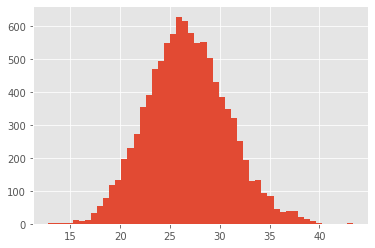

ShapiroResult(statistic=0.9942191243171692, pvalue=0.0006787715246900916)

In [25]:
check_mean(test_df.revenue)

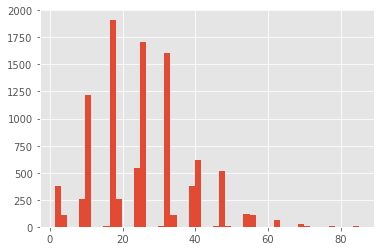

ShapiroResult(statistic=0.9593064188957214, pvalue=4.629821738594514e-16)

In [26]:
check_mean(control_df.revenue)

Как видно из анализа - распределение среднего в контрольной группе не является нормальным (тестовая группа так же не проходит порог в 0.05 в некоторых испытаниях), соответственно проводить t-test в этом случае будет некорректным решением

---

* *Пункт 2.2 (Bootstrap)*

In [27]:
def get_bootstrap(
    data_column_1,
    data_column_2,
    boot_it=10000,
    statistic=np.mean,
    bootstrap_conf_level=0.95,
    sample_len=5000
):
    boot_data = []
    for _ in range(boot_it):
        samples_1 = data_column_1.sample(
            sample_len,
            replace=True
        ).values

        samples_2 = data_column_2.sample(
            sample_len,
            replace=True
        ).values

        boot_data.append(statistic(samples_1) - statistic(samples_2))

    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])

    p_1 = stats.norm.cdf(
        x=0,
        loc=np.mean(boot_data),
        scale=np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x=0,
        loc=-np.mean(boot_data),
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        bar.set_facecolor('grey')
        bar.set_edgecolor('black')

    plt.vlines(quants, ymin=0, ymax=150, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()

    return {"boot_data": boot_data,
            "quants": quants,
            "p_value": p_value}

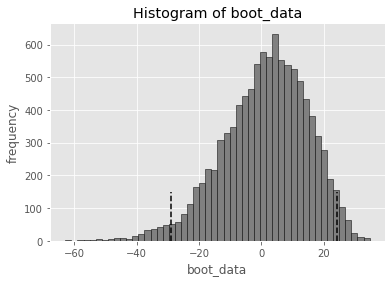

In [28]:
booted_data = get_bootstrap(test_df.revenue, control_df.revenue)

In [29]:
booted_data['p_value']

0.9238502133359051

**Bootstrap показал, что мы с большой долей уверенности можем заявлять о том, что изменение ARPU было случайным.**

---

* *Пункт 3 (ARPPU)*

In [30]:
# Создадим таблицы для платящих пользователей

test_payed_df = test_df.query('revenue > 0')
control_payed_df = control_df.query('revenue > 0')

In [31]:
test_ARPPU = test_payed_df.revenue.mean()

In [32]:
control_ARPPU = control_payed_df.revenue.mean()

In [33]:
ARPPU_diff = round((test_ARPPU - control_ARPPU) / control_ARPPU * 100, 2)

In [34]:
print('ARPPU в тестовой группе на {:.2f}% выше, чем в контрольной'
      .format(ARPPU_diff))

ARPPU в тестовой группе на 12.75% выше, чем в контрольной


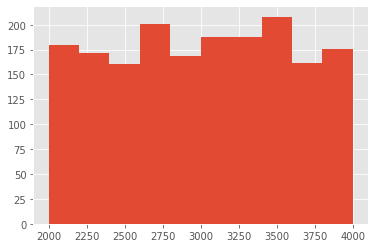

In [35]:
test_payed_df.revenue.hist()

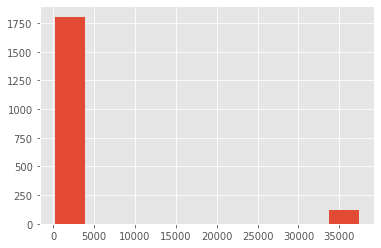

In [36]:
control_payed_df.revenue.hist()

Как видно из графиков, распределение для тестовой группы выглядит равномерным, в то время как у контрольной наблюдаются большие выбросы.
Но для математического док-ва применим тесты Шапиро-Уилка к ним.

In [37]:
print(stats.shapiro(control_payed_df.revenue.sample(1000, random_state=17)))
print(stats.shapiro(test_payed_df.revenue.sample(1000, random_state=17)))

ShapiroResult(statistic=0.26476240158081055, pvalue=0.0)
ShapiroResult(statistic=0.9613320827484131, pvalue=1.2885095898576755e-15)


---

* *Пункт 3.1 (t-test)*

Также посмотрим на распределение среднего для этих метрик.

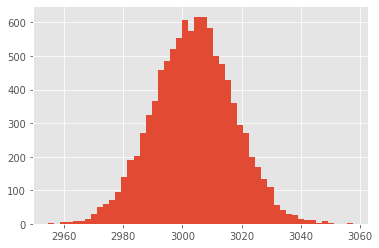

ShapiroResult(statistic=0.998997151851654, pvalue=0.8716865181922913)

In [38]:
check_mean(test_payed_df.revenue, sample_len=len(test_payed_df.revenue))

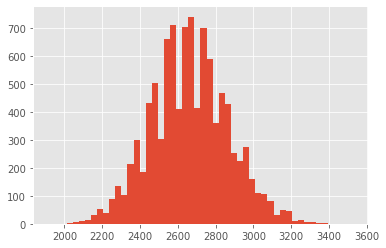

ShapiroResult(statistic=0.9979606866836548, pvalue=0.26656848192214966)

In [39]:
check_mean(control_payed_df.revenue, sample_len=len(control_payed_df.revenue))

In [40]:
stats.levene(test_payed_df.revenue, control_payed_df.revenue, center='mean')

LeveneResult(statistic=445.9869447066088, pvalue=1.3202514573715939e-93)

Распределение средних в обеих группах прошло тест на нормальность, но не выполняется условие о гомогенности дисперсий, соответственно применять t-test и в этом случае будет некорректно

---

* *Пункт 3.2 (Bootstrap)*

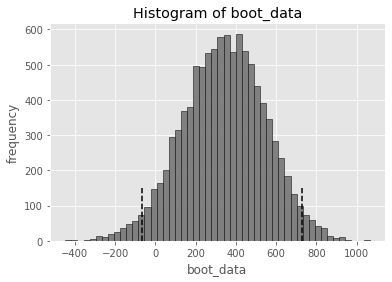

In [41]:
booted_data = get_bootstrap(test_payed_df.revenue,
                            control_payed_df.revenue,
                            sample_len=max(len(test_payed_df.revenue),
                                           len(control_payed_df.revenue))
                            )

In [42]:
booted_data['p_value']

0.09482513227919497

**Данный метод показал, что мы не можем считать разницу в ARPPU между группами стат. значимой.**

---

* *Пункт 4 (Конверсия)*

In [43]:
pd.crosstab(ab_df.is_client, ab_df.testgroup)

testgroup,a,b
is_client,,
False,200175,200862
True,1928,1805


In [44]:
# Конверсия тестовой группы

round(len(test_payed_df.revenue) / len(test_df.revenue) * 100, 2)

0.89

In [45]:
# Конверсия контрольной группы

round(len(control_payed_df.revenue) / len(control_df.revenue) * 100, 2)

0.95

Конверсия контрольной группы больше тестовой на 0.06 процентных пункта. Посмотрим на статистическю значимость этой разницы. Так как переменная категориальная, то применим хи-квадрат.

In [46]:
stats.chi2_contingency(pd.crosstab(ab_df.is_client, ab_df.testgroup))[1]

0.03647561892312613

**Можно утверждать, что показатели конверсии в контрольной группе значимо отличаются от тестовой**

---

* *Пункт 5 (Итоги)*

1) ARPU и ARPPU в тестовой группе выше, но эту разницу не удалось статистически подтвердить
2) Конверсия значительно выше в контрольной группе

Вывод: на данный момент у нас нет достаточной уверенности, чтобы выкатывать новые акционные предложения. Также необходимо проверить выбросы в контрольной группе на исторических данных и в случае аномалии внести изменения в систему сплитования для повторного тестирования.

#### *Задание 3*

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

1:

- Конверсия в покупку / просмотр рекламы / повторную покупку: так мы сможем отследить вовлеченность пользователей (кол-во первых покупок, увеличение покупок уже платящих пользователей)
- ARPU, ARPPU: для оценки финансовой успешности
- Онлайн / retention rate: сможем оценить популярность ивента
- В качестве обобщающей метрики для двух верхних пунктов можно использовать LTV 

Данные метрики можно использовать для сравнения как с общей активностью, так и для сравнения с активностью предыдущего ивента.

2:

Все метрики, которые были использованы выше останутся, но добавятся некоторые, с помощью которых можно будет дополнительно оценить популярность данного ивента для пользоваталей по сравнению со стандартными условиями.

- Churn rate: оценить, как часто пользователи выходят после неудачной попытки прохождения
- Конверсия по уровням: из этого можно узнать, какие уровни слишком сложны для пользователей